<a href="https://colab.research.google.com/github/Ntambe25/ECGR-8119-Applied-AI/blob/main/ECGR8119_Midterm_ModelB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECGR 8119 Applied AI - Midterm 1

In [ ]:
# Connecting the Google Drive to access the Folders with Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
import os
import random
import zipfile
import matplotlib.pyplot as plt
import shutil
import numpy as np
import torch
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from google.colab import files
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

from datetime import datetime

# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Checking GPU details
if device.type == 'cuda':
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Number of GPUs available: 1
GPU Name: Tesla T4


In [ ]:
# Specify the path to your zip file
zip_path = '/content/drive/MyDrive/ECGR_8119_Midterm_Contents/dogs-vs-cats/train.zip'

# Specify the directory where you want to extract the files
extract_to = '/content/'

# Create the directory if it does not exist
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
# Define the path to the folder containing the images
image_folder = '/content/train'

# Check if the directory exists
if os.path.exists(image_folder):
    # List all .jpg files in the directory
    jpg_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

    # Count the number of .jpg files
    num_jpg_files = len(jpg_files)

    # Print the count
    print(f"Number of .jpg files: {num_jpg_files}")
else:
    print(f"The directory {image_folder} does not exist.")

Number of .jpg files: 25000


In [ ]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt

# Paths to your directories in Colab
source_dir = '/content/train'  # Update this if your path is different
destination_dir = '/content/unzipped_files'

# Create destination directories if they don't exist
cat_dir = os.path.join(destination_dir, 'cats')
dog_dir = os.path.join(destination_dir, 'dogs')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Organize files (COPY instead of move)
for filename in os.listdir(source_dir):
    if filename.startswith('cat'):
        shutil.copy(os.path.join(source_dir, filename), os.path.join(cat_dir, filename))  # Copy instead of move
    elif filename.startswith('dog'):
        shutil.copy(os.path.join(source_dir, filename), os.path.join(dog_dir, filename))  # Copy instead of move

print('Images have been organized into separate directories successfully (copies created).')

Images have been organized into separate directories successfully (copies created).


In [ ]:
import os
import shutil

# Define paths
source_dir = '/content/drive/MyDrive/ECGR_8119_Midterm_Contents/generated_images'
destination_dir = '/content/unzipped_files'
cat_dir = os.path.join(destination_dir, 'cats')
dog_dir = os.path.join(destination_dir, 'dogs')

# Function to classify and move images based on naming convention
def move_cat_dog_files(source_dir, cat_dir, dog_dir):
    for filename in os.listdir(source_dir):
        file_path = os.path.join(source_dir, filename)

        # Check if it's an image file
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Move to the appropriate directory based on the name
            if 'dog' in filename.lower():
                shutil.move(file_path, os.path.join(dog_dir, filename))
            elif 'cat' in filename.lower():
                shutil.move(file_path, os.path.join(cat_dir, filename))

# Move the files
move_cat_dog_files(source_dir, cat_dir, dog_dir)

print("Images have been successfully moved into 'cats' and 'dogs' directories in 'unzipped_files'.")

Images have been successfully moved into 'cats' and 'dogs' directories in 'unzipped_files'.


In [ ]:
# Paths to your directories
base_dir = '/content/unzipped_files'
cat_dir = os.path.join(base_dir, 'cats')
dog_dir = os.path.join(base_dir, 'dogs')

# Function to split image files into training and test lists
def get_train_test_splits(source_dir, test_size=0.3):
    files = [
        os.path.join(source_dir, f) for f in os.listdir(source_dir)
        if f.endswith(('.jpg', '.jpeg', '.png'))
    ]
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
    return train_files, test_files

# Get the file paths for cats and dogs, splitting into train and test sets
train_cat_files, test_cat_files = get_train_test_splits(cat_dir)
train_dog_files, test_dog_files = get_train_test_splits(dog_dir)

# Output the results
print(f"Number of training cat images: {len(train_cat_files)}")
print(f"Number of test cat images: {len(test_cat_files)}")
print(f"Number of training dog images: {len(train_dog_files)}")
print(f"Number of test dog images: {len(test_dog_files)}")

Number of training cat images: 10500
Number of test cat images: 4500
Number of training dog images: 10500
Number of test dog images: 4500


In [ ]:
# Create labels for cats and dogs (0 for cats, 1 for dogs)
def create_dataframe(file_list, label):
    return pd.DataFrame({'filename': file_list, 'label': [str(label)] * len(file_list)})  # Convert label to string

# Create DataFrames for training and test sets
train_cat_df = create_dataframe(train_cat_files, 0)
train_dog_df = create_dataframe(train_dog_files, 1)
test_cat_df = create_dataframe(test_cat_files, 0)
test_dog_df = create_dataframe(test_dog_files, 1)

# Concatenate cat and dog dataframes for both training and test sets
train_df = pd.concat([train_cat_df, train_dog_df]).reset_index(drop=True)
test_df = pd.concat([test_cat_df, test_dog_df]).reset_index(drop=True)

# Shuffle the dataframes
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Output some details about the data
print(f"Training set size: {train_df.shape[0]} images")
print(f"Test set size: {test_df.shape[0]} images")

# Display the first few rows of the training and test sets
print(train_df.head())
print(test_df.head())

Training set size: 21000 images
Test set size: 9000 images
                                            filename label
0  /content/unzipped_files/cats/generated_cat_171...     0
1          /content/unzipped_files/dogs/dog.7873.jpg     1
2  /content/unzipped_files/cats/generated_cat_226...     0
3          /content/unzipped_files/cats/cat.9577.jpg     0
4          /content/unzipped_files/dogs/dog.6344.jpg     1
                                            filename label
0         /content/unzipped_files/cats/cat.11619.jpg     0
1  /content/unzipped_files/dogs/generated_dog_815...     1
2           /content/unzipped_files/cats/cat.741.jpg     0
3          /content/unzipped_files/dogs/dog.5586.jpg     1
4          /content/unzipped_files/dogs/dog.8000.jpg     1


In [ ]:
# Set image dimensions and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create ImageDataGenerators for augmenting training data and rescaling test data
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=40,        # Random rotations
    width_shift_range=0.2,    # Random horizontal shifts
    height_shift_range=0.2,   # Random vertical shifts
    shear_range=0.2,          # Random shear transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flips
    fill_mode='nearest'       # Filling in newly created pixels
)

# For test set, only rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for training and test sets
train_generator = train_datagen.flow_from_dataframe(
    train_df,                        # DataFrame containing file paths and labels
    x_col='filename',                # Column containing image file paths
    y_col='label',                   # Column containing labels (0 for cat, 1 for dog)
    target_size=IMG_SIZE,            # Resize images to MobileNet input size
    batch_size=BATCH_SIZE,
    class_mode='binary',             # Binary classification
    shuffle=True                     # Shuffle the data
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,                         # DataFrame for test set
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',             # Binary classification
    shuffle=False                    # No need to shuffle test data
)

Found 21000 validated image filenames belonging to 2 classes.
Found 9000 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model without the top layer (fully connected layers)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers to prevent them from being updated during training
for layer in mobilenet_base.layers:
    layer.trainable = False

# Add custom layers on top of the MobileNetV2 base
x = Flatten()(mobilenet_base.output)         # Flatten the output of the convolutional layers
x = Dense(256, activation='relu')(x)   # Add a fully connected layer
x = Dense(1, activation='sigmoid')(x)  # Add the output layer (binary classification)

# Create the full model
model = Model(inputs=mobilenet_base.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 7,501,377 (28.62 MB)

 Trainable params: 5,243,393 (20.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,                          # Number of epochs
    validation_data=None                # No Validation data
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


657/657 ━━━━━━━━━━━━━━━━━━━━ 163s 229ms/step - accuracy: 0.8329 - loss: 0.7103
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 173s 194ms/step - accuracy: 0.8973 - loss: 0.2224
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.9027 - loss: 0.2123
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 143s 190ms/step - accuracy: 0.9063 - loss: 0.2086
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 139s 185ms/step - accuracy: 0.9047 - loss: 0.2079
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 141s 184ms/step - accuracy: 0.9079 - loss: 0.2020
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 145s 189ms/step - accuracy: 0.9094 - loss: 0.2033
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 124s 186ms/step - accuracy: 0.9155 - loss: 0.1911
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 141s 185ms/step - accuracy: 0.9125 - loss: 0.1978
Epoch 10/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 141s 183ms/step - accuracy: 0.9125 - loss: 0.1929


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Step 1: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9394 - loss: 0.1496
Test Loss: 0.15288200974464417
Test Accuracy: 0.9356094598770142


In [ ]:
# Step 2: Generate predictions and true labels from the test set
y_true = []
y_pred = []
y_prob = []

for x_batch, y_batch in test_generator:
    # Get model predictions (probabilities)
    batch_predictions = model.predict(x_batch)

    # Append true labels
    y_true.extend(y_batch)

    # Append probabilities for AUC
    y_prob.extend(batch_predictions)

    # Convert probabilities to binary predictions using a threshold of 0.5
    y_pred.extend((batch_predictions > 0.5).astype(int))

    # Break if enough samples are collected
    if len(y_true) >= test_generator.samples:
        break

# Step 3: Calculate Precision, Recall, F1 Score, and AUC
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Print results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Save the trained model in the recommended Keras format
model.save('/content/drive/MyDrive/ECGR_8119_Midterm_Contents/saved_model/MobilenetV2_ModelB.keras')

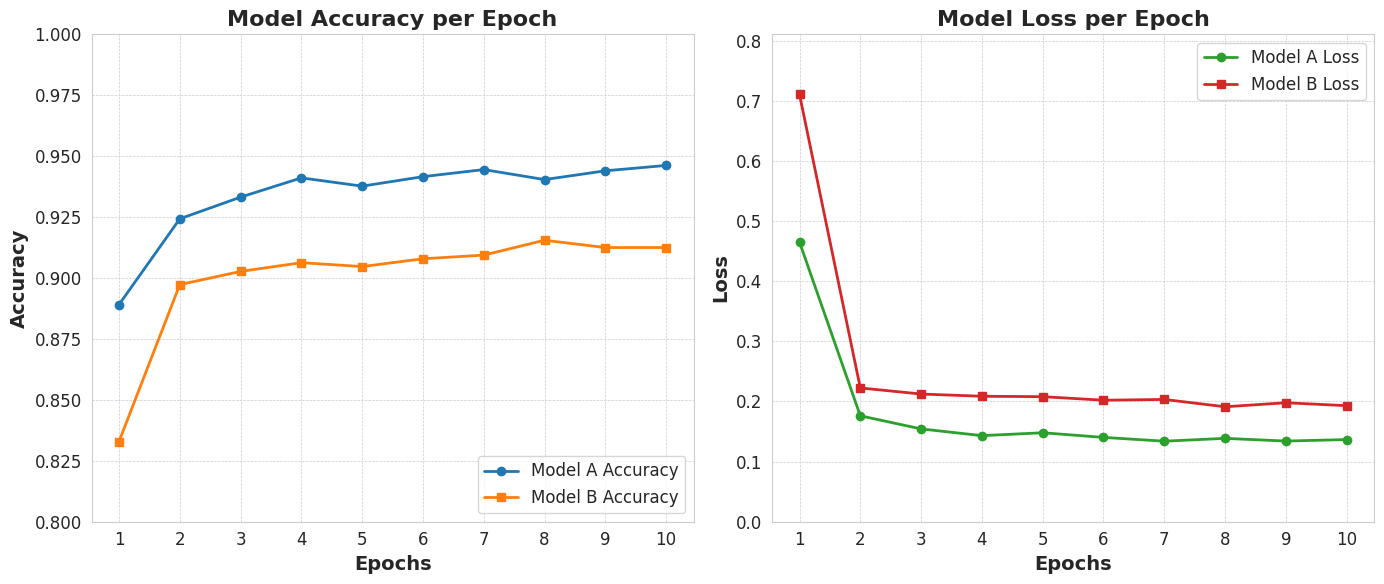

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting a style with seaborn for a fancier look
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'axes.labelweight': 'bold'})

# Model A values
accuracy_a = [0.8891, 0.9243, 0.9332, 0.9411, 0.9377, 0.9416, 0.9445, 0.9404, 0.9440, 0.9462]
loss_a = [0.4649, 0.1761, 0.1543, 0.1431, 0.1479, 0.1402, 0.1339, 0.1386, 0.1341, 0.1366]

# Model B values
accuracy_b = [0.8329, 0.8973, 0.9027, 0.9063, 0.9047, 0.9079, 0.9094, 0.9155, 0.9125, 0.9125]
loss_b = [0.7103, 0.2224, 0.2123, 0.2086, 0.2079, 0.2020, 0.2033, 0.1911, 0.1978, 0.1929]

# Epochs
epochs = range(1, 11)

# Setting figure size and DPI for a high-quality output
plt.figure(figsize=(14, 6), dpi=100)

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_a, 'o-', color='#1f77b4', linewidth=2, markersize=6, label='Model A Accuracy')
plt.plot(epochs, accuracy_b, 's-', color='#ff7f0e', linewidth=2, markersize=6, label='Model B Accuracy')
plt.title('Model Accuracy per Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(epochs)
plt.ylim(0.8, 1)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_a, 'o-', color='#2ca02c', linewidth=2, markersize=6, label='Model A Loss')
plt.plot(epochs, loss_b, 's-', color='#d62728', linewidth=2, markersize=6, label='Model B Loss')
plt.title('Model Loss per Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(epochs)
plt.ylim(0, max(max(loss_a), max(loss_b)) + 0.1)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show layout and final plot
plt.tight_layout()
plt.show()

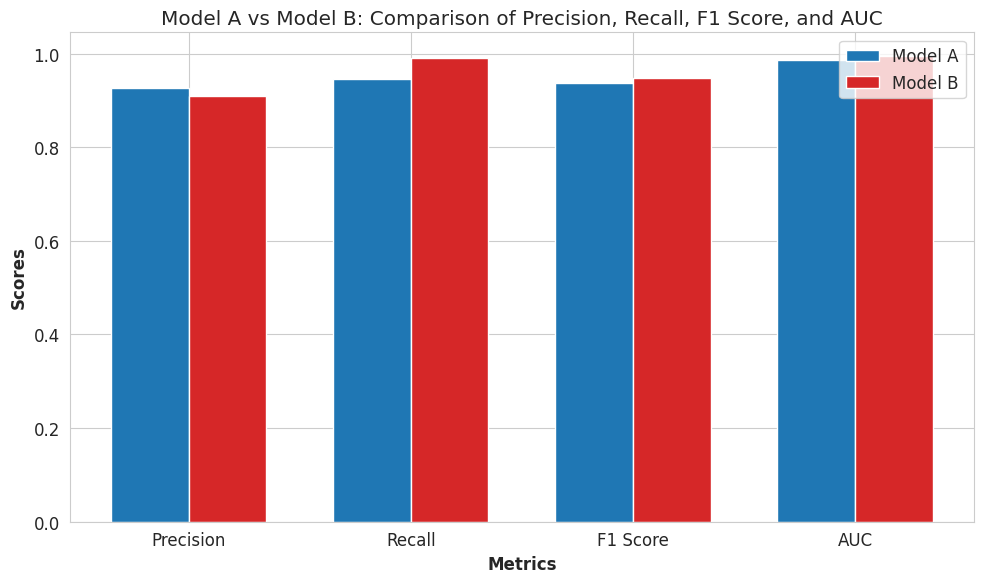

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model A Results
precision_A = 0.9273877017008286
recall_A = 0.9451111111111111
f1_score_A = 0.9361655293858684
auc_A = 0.9863880987654321

# Model B Results
precision_B = 0.9101151114376684
recall_B = 0.9909333333333333
f1_score_B = 0.9488063321843483
auc_B = 0.9956101333333333

# Labels for the metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'AUC']

# Model A and Model B results for each metric
model_A_results = [precision_A, recall_A, f1_score_A, auc_A]
model_B_results = [precision_B, recall_B, f1_score_B, auc_B]

# Set the positions for the bars
x = np.arange(len(metrics))

# Bar width
width = 0.35

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars for both models
bars_A = ax.bar(x - width/2, model_A_results, width, label='Model A', color='tab:blue')
bars_B = ax.bar(x + width/2, model_B_results, width, label='Model B', color='tab:red')

# Adding labels, title, and custom x-axis ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model A vs Model B: Comparison of Precision, Recall, F1 Score, and AUC')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Adding a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()